Install TensorFlow, GPflow and PTable

In [ ]:
! pip install tensorflow==2.2.0 gpflow==2.0.0 tensorboard==2.1.1 ptable

print('All packages installed')

Install LaTeX for figure rendering

In [17]:
# See https://stackoverflow.com/questions/55746749/latex-equations-do-not-render-in-google-colaboratory-when-using-matplotlib

! sudo apt-get install texlive-latex-recommended #1
! sudo apt-get install dvipng texlive-fonts-recommended #2
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3
! unzip type1cm.zip -d /tmp/type1cm #4
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5
! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm #7
! sudo texhash #8

! wget https://ctan.org/tex-archive/fonts/ps-type1/cm-super/type1ec.sty
! sudo cp type1ec.sty /usr/share/texmf/tex/latex/type1cm

! sudo texhash

print('TeX fonts installed')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lmodern fonts-noto-mono libcupsfilters1
  libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0 libkpathsea6
  libpotrace0 libptexenc1 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13
  lmodern poppler-data t1utils tex-common texlive-base texlive-binaries
  texlive-latex-base
Suggested packages:
  fonts-noto poppler-utils ghostscript fonts-japanese-mincho
  | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fonts-arphic-uming fonts-nanum debhelper gv
  | postscript-viewer perl-tk xpdf-reader | pdf-viewer texlive-latex-base-doc
  texlive-latex-recommended-doc texlive-pstricks
The following NEW packages will be installed:
  fonts-d

Load repository

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

% cd "gdrive/My Drive/Projects/BNQD v2"


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Projects/BNQD v2


In [15]:
import gpflow
from gpflow.kernels import Matern32, Matern52, SquaredExponential, Linear, Bias, Exponential, Polynomial, Cosine, Periodic, RationalQuadratic
from BNQD import BNQD
import numpy as np

# Example 1

true discontinuity: 6.00
+-----------------------------------------------------------------------------------------------------------------------+
|                                                      BNQD report                                                      |
+------------------------+-----------+----------+----------+-----------+-----------+-------------+------------+---------+
| Kernel                 | log BF_10 | p(m_0|D) | p(m_1|D) |  p(D|m_0) |  p(D|m_1) | E[p(d|m_1)] | V[p(d|m1)] | E[p(d)] |
+------------------------+-----------+----------+----------+-----------+-----------+-------------+------------+---------+
| Polynomial (d=1)       |    6.4460 |   0.0016 |   0.9984 | -142.2478 | -135.8018 |      6.9329 |    17.3583 |  6.9219 |
| Matern32               |    2.4056 |   0.0827 |   0.9173 | -138.8918 | -136.4861 |      6.9251 |    18.3401 |  6.3521 |
| Rational_quadratic     |    1.6275 |   0.1642 |   0.8358 | -139.7455 | -138.1179 |      6.3824 |    17.8974 |  5.3346 |

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


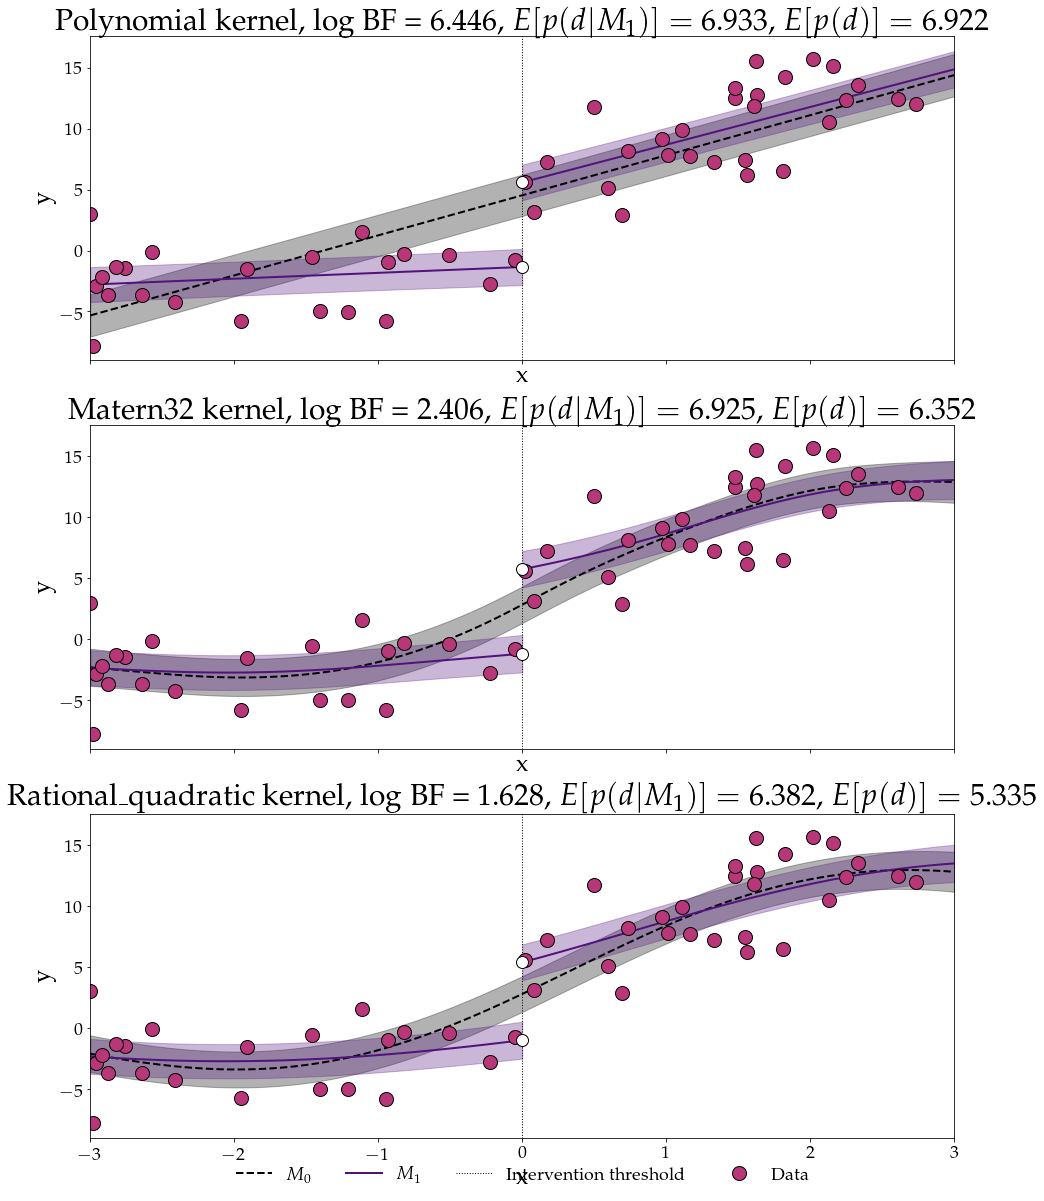

In [18]:
sigma = 2.0
n = 50  

x = np.random.uniform(-3, 3, n)

ip = 0.0  # single intervention point
d = 6.0 # true effect size
f = 1.1*x + 3*np.sin(x) + 0.3*x**2 + d*(x>ip)  
y = f + sigma*np.random.standard_t(df=5, size=n)

lb, ub = -3, 3

xpred = np.linspace(lb, ub, 101)

kernel_list = [Polynomial(degree=1), Matern32(), RationalQuadratic()]

bqed = BNQD((x, y), kernel_list, ip)
bqed.train()

plot_opts = dict()
plot_opts['width'] = 12
plot_opts['height'] = 6
plot_opts['markersize'] = 14

fig = bqed.plot(xpred, plot_opts=plot_opts)

print('true discontinuity: {:0.2f}'.format(d))


Plot the effect sizes for the same kernels:

In [ ]:
bqed.plot_effect_size()

Print the numerical results in a table:

In [ ]:
print(bqed.tabular_results())

# Example 2: sample hyperparameters with HMC

Note: this takes some time.

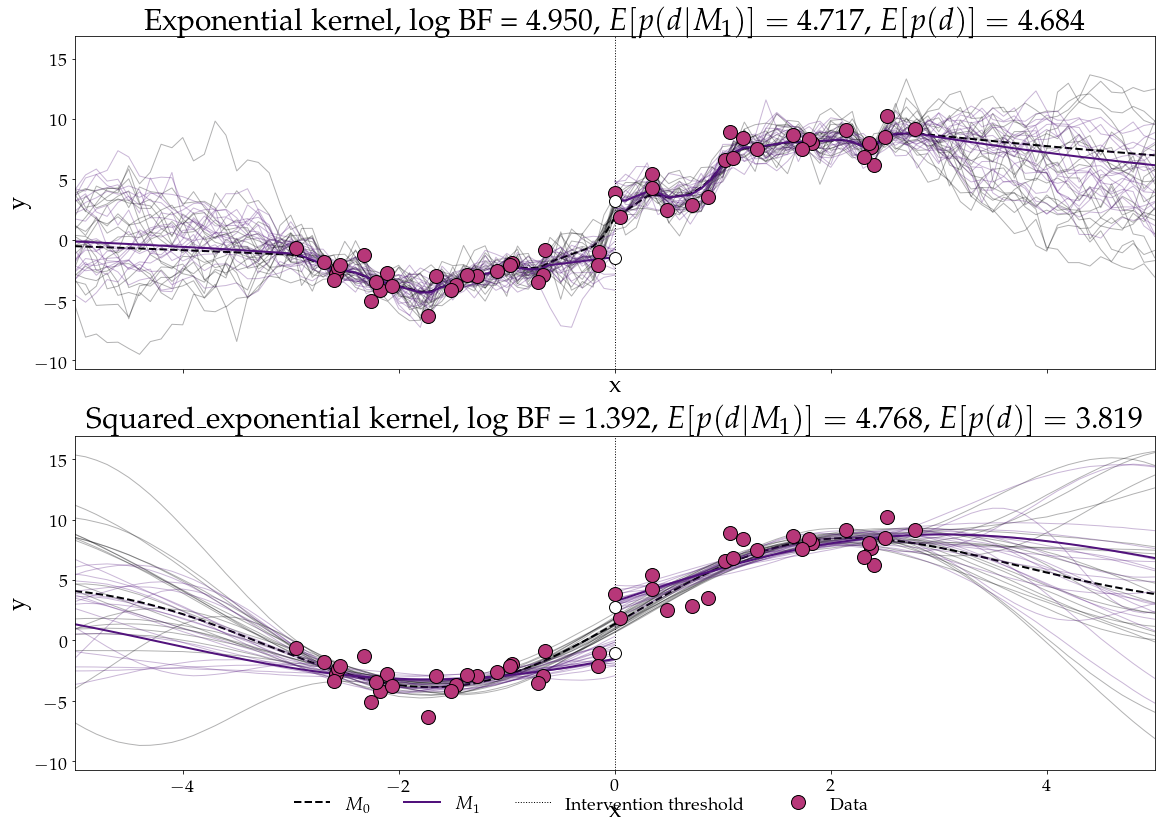

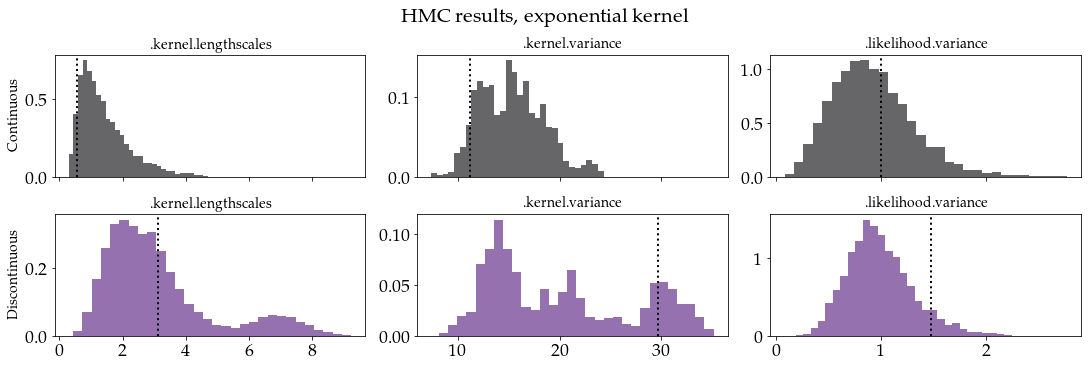

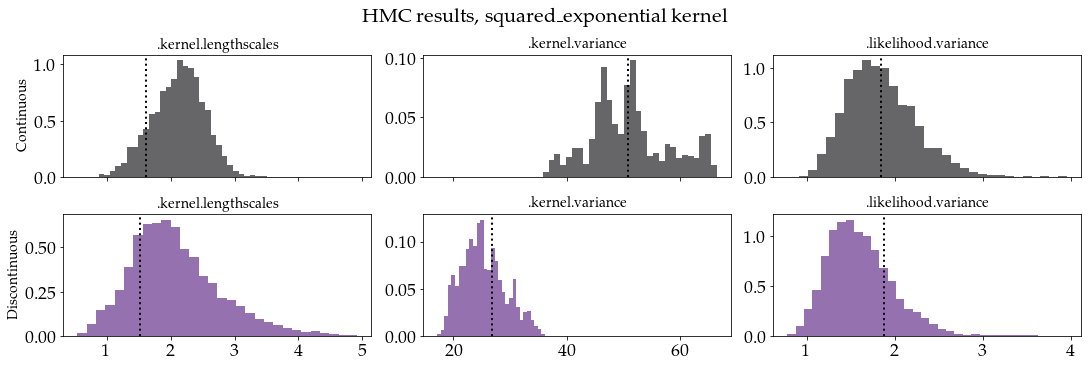

In [19]:
sigma = 1.0
n = 50  

x = np.random.uniform(-3, 3, n)

ip = 0.0  # single intervention point
d = 2.0 # true effect size
f = 1.1*x + 3*np.sin(x) + 0.3*x**2 + d*(x>ip)  
y = np.random.normal(f, sigma)

lb, ub = -5, 5

xpred = np.linspace(lb, ub, 101)

kernel_list = [Exponential(), SquaredExponential()]

bqed = BNQD((x, y), kernel_list, ip)


bqed.train(verbose=False, posterior=True)
bqed.plot(xpred, plot_samples=True)
bqed.plot_hmc_params()


# Example 3: simulation on several functions

See the accompanying manuscript and Branson et al., 2019.

Note: every one in a while the optimiser throws an error. Usually a simple restart fixes this.

Text(0.5, 0.98, '')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


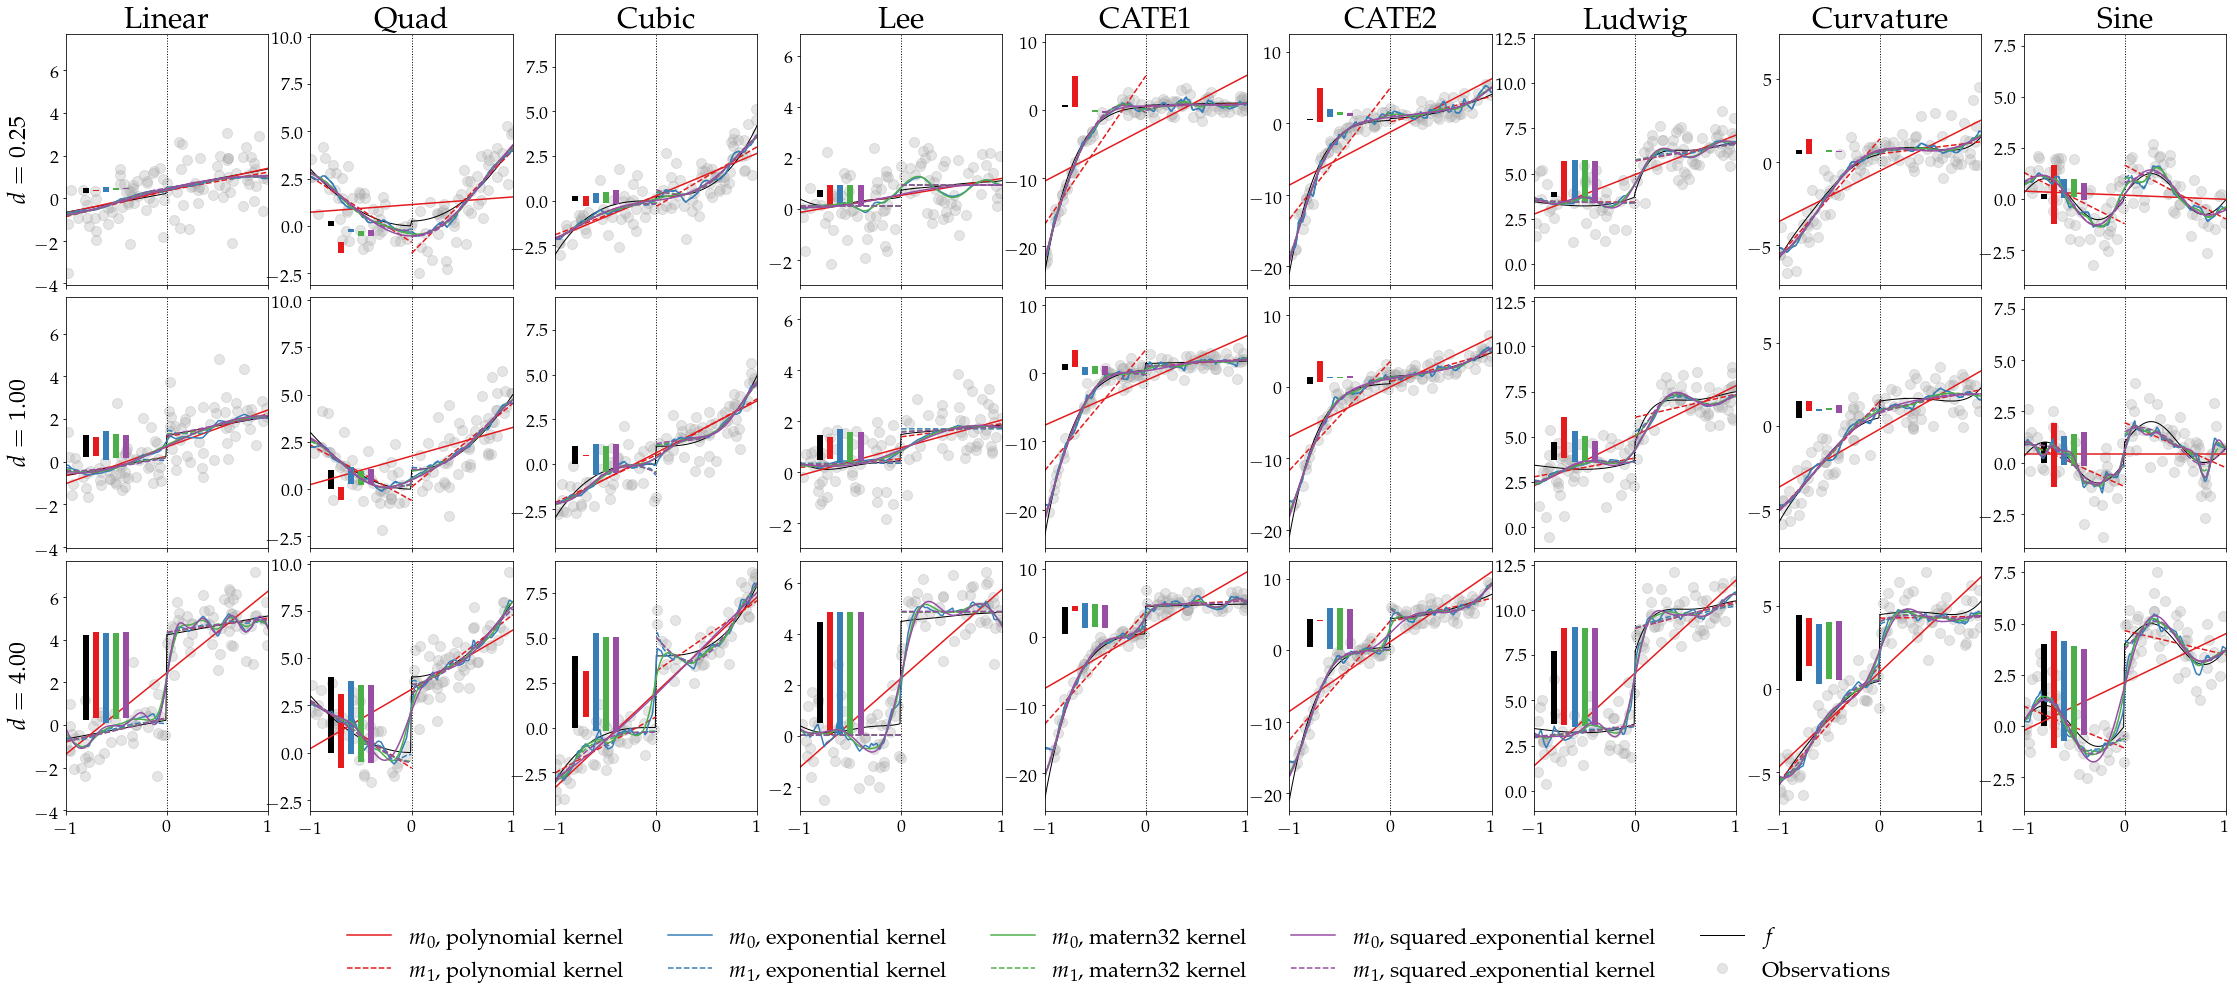

In [24]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
color_cycle = cm.magma(np.linspace(0, 1, 5))


f_lee       = lambda x, b: (x < b)*(0.48+1.27*x +7.18*x**2 + 20.21*x**3 + 21.54*x**4 + 7.33*x**5) + (x >= b)*(0.48 + 0.84*x - 3.0*x**2 + 7.99*x**3 - 9.01*x**4 + 3.56*x**5)
f_linear    = lambda x, b: (x < b)*(0.23 + 0.89*x) + (x >=b )*(0.23 + 0.89*x)
f_quad      = lambda x, b: (x < b)*(3*x**2) + (x >= b)*(4*x**2)
f_cubic     = lambda x, b: (x < b)*(3*x**3) + (x >= b)*(4*x**3)
f_cate1     = lambda x, b: 0.42+ 0.84*x -3.00*x**2 +7.99*x**3 -9.01*x**4 +3.56*x**5
f_cate2     = lambda x, b: 0.42+ 0.84*x +7.99*x**3 -9.01*x**4 +3.56*x**5
f_ludwig    = lambda x, b: (x < b)*( 3.71 + 2.30*x + 3.28*x**2 + 1.45*x**3 + 0.23*x**4 + 0.03*x**5 ) + (x >= b) * (3.71 + 18.49*x - 54.81*x**2 + 74.30*x**3 - 45.02*x**4 + 9.83*x**5)
f_curvature = lambda x, b: (x < b)*(0.48 + 1.27*x - 0.5 * 7.18*x**2 + 0.7*20.21*x**3 + 1.1 *21.54*x**4 + 1.5 *7.33*x**5) + (x >= b)*(0.48 + 0.84*x - 0.1*3.00*x**2 - 0.3*7.99*x**3 - 0.1*9.01*x**4 + 3.56*x**5)
f_sine      = lambda x, b: sigma*np.sin(x * 6.) 

fs      = [f_linear, f_quad, f_cubic, f_lee, f_cate1, f_cate2, f_ludwig, f_curvature, f_sine]
fnames  = ['Linear', 'Quad', 'Cubic', 'Lee', 'CATE1', 'CATE2', 'Ludwig', 'Curvature', 'Sine']
n = 100
sigma = 1.0 # 0.1295
b = 0.0
xrange = np.linspace(-1, 1, 201)

kernels = [Polynomial(degree=1), Exponential(), Matern32(), SquaredExponential()]

snrs = [0.25, 1.0, 4.0]

K = len(kernels)
F = len(fs)
S = len(snrs)

colors = cm.Set1(range(K))

bar_offset = np.linspace(-0.8, -0.4, K+1)
bw = 6

m1_es = np.zeros((F, K, S))
bma_es = np.zeros((F, K, S))

fig, axes = plt.subplots(nrows=S, ncols=F, figsize=(30,5*S), sharex=True, sharey='col')

for s, snr in tqdm(enumerate(snrs)):
  d = snr * sigma

  for i, f in enumerate(fs):
    ax = axes[s,i]
    x = np.random.uniform(-1, 1, size=n)

    true_latent_f = f(xrange, b) + d*(xrange>=b)
    true_obs_f = f(x, b) + d*(x >= b)
   
    y = np.random.normal(loc=true_obs_f, scale=sigma)    
    
    ax.axvline(x=b, ls=':', c='k', lw=1.0)
    ax.set_xlim([-1, 1])

    bqed = BNQD((x, y), kernels, ip=b)
    bqed.train()
    
    es_d = bqed.discontinuous_effect_size_mean_var()
    es_bma = bqed.bma_effect_size()
    bfs = bqed.get_bayes_factor()

    ax.plot([bar_offset[0], bar_offset[0]], [f(b,b), f(b,b)+d], ls='-', c='k', 
            lw=bw, solid_capstyle='butt')

    for k in range(K):
      m1_es[i, k, s] = es_d[k][0]
      bma_es[i, k, s] = es_bma[k]
      mu_c, _ = bqed.m0[k].predict_y(xrange[:, None])
      preds_d = bqed.m1[k].predict_y(Xnew_list=[xrange[xrange<=b, None], 
                                                xrange[xrange>=b, None]])
      ax.plot(xrange, mu_c, c=colors[k,:], ls='-', 
              label='$m_0$, {:s} kernel'.format(kernels[k].name.replace('_', '\_')))
      ax.plot(xrange[xrange<=b], preds_d[0][0], c=colors[k,:], ls='--', 
              label='$m_1$, {:s} kernel'.format(kernels[k].name.replace('_', '\_')))
      ax.plot(xrange[xrange>=b], preds_d[1][0], c=colors[k,:], ls='--')
      y_anchor = ax.get_ylim()[0]
      y_pos = y_anchor*1.2 if y_anchor > 0 else y_anchor*0.8

      preds_d_b = bqed.m1[k].predict_y(2*[np.atleast_2d(b)])
      y0, y1 = preds_d_b[0][0].numpy().flatten(), preds_d_b[1][0].numpy().flatten()
      if y0 > y1:        
        tmp = y0
        y0 = y1
        y1 = tmp

      if y1 - y0 < 0.03:
        # minimum line length
        y1 += 0.015
        y0 -= 0.015

      ax.plot([bar_offset[k+1], bar_offset[k+1]], [y0, y1], lw=bw, 
              c=colors[k,:], solid_capstyle='butt')
    
    ax.plot(xrange[xrange<=b], true_latent_f[xrange<=b], lw=1.0, ls='-', c='k', 
            label='$f$', zorder=-5)
    ax.plot(xrange[xrange>=b], true_latent_f[xrange>=b], lw=1.0, ls='-', c='k', 
            zorder=-5)
    ax.plot(x, y, ls='none', c='darkgrey', marker='o', alpha=0.3, ms=10, label='Observations', zorder=-6)
    
  axes[s,0].set_ylabel(r'$d={:0.2f}$'.format(snr))

for i, ax in enumerate(axes[0,:]):
  ax.set_title(fnames[i])

handles, labels = axes[-1,-1].get_legend_handles_labels()
plt.subplots_adjust(hspace=0.05, wspace=0.21, left=0, right=1.0, top=0.9, bottom=0.18)
plt.figlegend(handles, labels, frameon=False, ncol=K+1, fontsize=22,
                    loc='lower center')
plt.suptitle('')

